# Probabilistic Regression with TFP

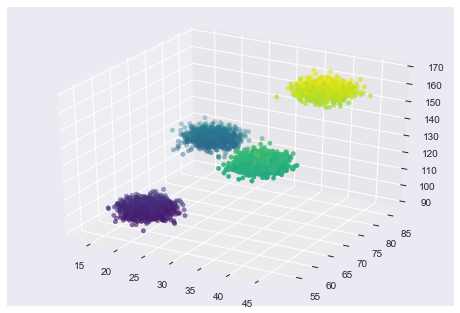

In [4]:
from data.synthetic import get_normal_data, plot_data

X, y = get_normal_data(1000)
plot_data(X, y)

In [31]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
negloglik = lambda y, rv_y: -rv_y.log_prob(y)
tf.keras.backend.set_floatx('float64')

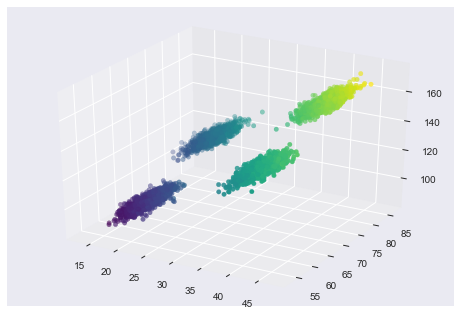

In [23]:
# No uncertainty
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(X, y, epochs=1000, verbose=False)
yhat = model(X)
plot_data(X, yhat)

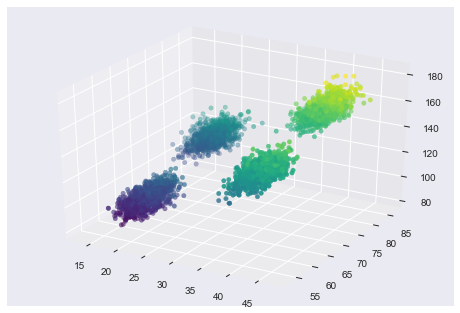

In [24]:
# Aleatoric uncertainty
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1 + 1),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :1],
                             scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(X, y, epochs=1000, verbose=False)
yhat = model(X)
plot_data(X, yhat)


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



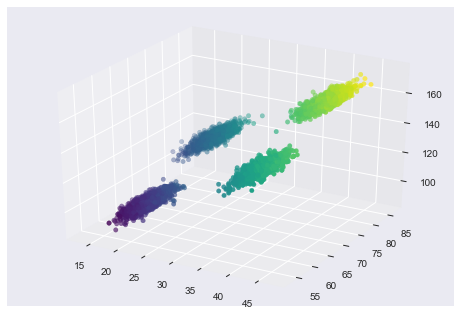

In [28]:
# Epistemic uncertainty
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/X.shape[0]),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(X, y, epochs=1000, verbose=False)
yhat = model(X)
plot_data(X, yhat)


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



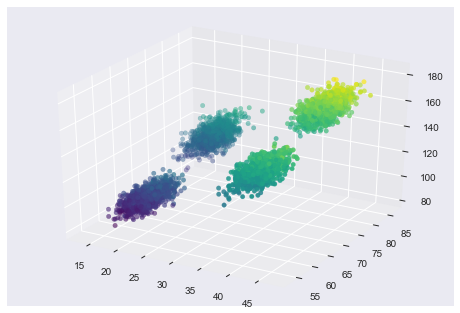

In [29]:
# Aleatoric and epistemic uncertainty
model = tf.keras.Sequential([
    tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/X.shape[0]),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :1],
                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(X, y, epochs=1000, verbose=False)
yhat = model(X)
plot_data(X, yhat)